In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix
from sklearn.tree import DecisionTreeClassifier # For baseline classification
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor # For regression and classification
import xgboost as xgb
import lightgbm as lgb
import shap
import pickle
from imblearn.over_sampling import SMOTE # For classification imbalance
import os
import warnings

warnings.filterwarnings('ignore', category=UserWarning, module='xgboost') # Suppress XGBoost UserWarning for label encoder
warnings.filterwarnings('ignore', category=FutureWarning) # Suppress some FutureWarning from libraries
pd.options.mode.chained_assignment = None # Suppress SettingWithCopyWarning, use with caution

In [2]:
file_path = 'crop_yield - Copy.csv' # Ensure this file is in the same directory or provide the full path
try:
    crop_yield_data_original = pd.read_csv(file_path)
    print(f"Successfully loaded data from {file_path}")
    print(f"Original dataset shape: {crop_yield_data_original.shape}")
except FileNotFoundError:
    print(f"ERROR: File not found at {file_path}. Please check the path.")
    # You might want to stop execution here if the file isn't found
    # For now, creating a dummy dataframe if file not found to allow rest of notebook to run
    crop_yield_data_original = pd.DataFrame({
        'Crop': ['Rice', 'Wheat', 'Maize'] * 100,
        'Crop_Year': [2000, 2001, 2000] * 100,
        'Season': ['Kharif', 'Rabi', 'Kharif'] * 100,
        'State': ['Punjab', 'Haryana', 'Punjab'] * 100,
        'Area': np.random.rand(300) * 1000,
        'Production': np.random.rand(300) * 5000,
        'Annual_Rainfall': np.random.rand(300) * 2000 + 500,
        'Fertilizer': np.random.rand(300) * 100000 + 50000,
        'Pesticide': np.random.rand(300) * 5000 + 1000,
        'Yield': np.random.rand(300) * 10 + 0.5
    })
    print("WARNING: crop_yield.csv not found. Using dummy data for demonstration.")


df_reg = crop_yield_data_original.copy() # For regression task
df_class_orig = crop_yield_data_original.copy() # For classification task

Successfully loaded data from crop_yield - Copy.csv
Original dataset shape: (999, 10)


In [3]:
print("--- Initial Data Inspection (Regression DataFrame) ---")
print("Head:")
print(df_reg.head())
print("\nInfo:")
df_reg.info()
print("\nDescribe (Numerical):")
print(df_reg.describe())
print("\nDescribe (Object):")
print(df_reg.describe(include='object'))
print("\nMissing Values:")
print(df_reg.isnull().sum())

--- Initial Data Inspection (Regression DataFrame) ---
Head:
           Crop  Crop_Year       Season  State   Area  Production  \
0      Arecanut       1997  Whole Year   Assam  73814       56708   
1     Arhar/Tur       1997  Kharif       Assam   6637        4685   
2   Castor seed       1997  Kharif       Assam    796          22   
3      Coconut        1997  Whole Year   Assam  19656   126905000   
4  Cotton(lint)       1997  Kharif       Assam   1739         794   

   Annual_Rainfall  Fertilizer  Pesticide        Yield  
0           2051.4  7024878.38   22882.34     0.796087  
1           2051.4   631643.29    2057.47     0.710435  
2           2051.4    75755.32     246.76     0.238333  
3           2051.4  1870661.52    6093.36  5238.051739  
4           2051.4   165500.63     539.09     0.420909  

Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 999 entries, 0 to 998
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --

In [4]:
print("\n--- Preprocessing for Regression ---")
# Drop 'Production' as Yield is the target
if 'Production' in df_reg.columns:
    df_reg = df_reg.drop(columns=['Production'])

# Trim whitespace from object columns
for col in df_reg.select_dtypes(include='object').columns:
    df_reg[col] = df_reg[col].str.strip()

# Handle missing values (imputation)
# Numerical: Median imputation
for col in df_reg.select_dtypes(include=np.number).columns:
    if df_reg[col].isnull().any():
        median_val = df_reg[col].median()
        df_reg[col] = df_reg[col].fillna(median_val)
        print(f"Filled NaNs in numerical column '{col}' with median: {median_val}")

# Categorical: Mode imputation
for col in df_reg.select_dtypes(include='object').columns:
    if df_reg[col].isnull().any():
        mode_val = df_reg[col].mode()[0]
        df_reg[col] = df_reg[col].fillna(mode_val)
        print(f"Filled NaNs in categorical column '{col}' with mode: {mode_val}")

print("\nMissing values after imputation (Regression DataFrame):")
print(df_reg.isnull().sum())


--- Preprocessing for Regression ---

Missing values after imputation (Regression DataFrame):
Crop               0
Crop_Year          0
Season             0
State              0
Area               0
Annual_Rainfall    0
Fertilizer         0
Pesticide          0
Yield              0
dtype: int64


In [5]:
numerical_cols_reg = ['Area', 'Annual_Rainfall', 'Fertilizer', 'Pesticide', 'Yield']
for col in numerical_cols_reg:
    Q1 = df_reg[col].quantile(0.25)
    Q3 = df_reg[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    # Cap outliers
    df_reg[col] = np.where(df_reg[col] < lower_bound, lower_bound, df_reg[col])
    df_reg[col] = np.where(df_reg[col] > upper_bound, upper_bound, df_reg[col])
print("\nOutliers handled by capping (Regression DataFrame).")


Outliers handled by capping (Regression DataFrame).


In [6]:
categorical_cols_reg = ['State', 'Crop', 'Season']

# Store original mappings for dropdowns BEFORE encoding
categorical_mappings = {}
for col in categorical_cols_reg:
    categorical_mappings[col] = sorted(df_reg[col].astype(str).unique().tolist())

label_encoders_reg = {}
for col in categorical_cols_reg:
    le = LabelEncoder()
    df_reg[col] = le.fit_transform(df_reg[col])
    label_encoders_reg[col] = le
print("\nCategorical features encoded (Regression DataFrame).")


Categorical features encoded (Regression DataFrame).


In [7]:
feature_names_ordered = ['State', 'Crop', 'Season', 'Area', 'Crop_Year', 'Annual_Rainfall', 'Fertilizer', 'Pesticide']

X_reg = df_reg[feature_names_ordered]
y_reg = df_reg['Yield']

print("\nFeatures (X_reg) head after encoding:")
print(X_reg.head())


Features (X_reg) head after encoding:
   State  Crop  Season     Area  Crop_Year  Annual_Rainfall  Fertilizer  \
0      1     0       4  73814.0       1997           2051.4  7024878.38   
1      1     1       1   6637.0       1997           2051.4   631643.29   
2      1     8       1    796.0       1997           2051.4    75755.32   
3      1     9       4  19656.0       1997           2051.4  1870661.52   
4      1    11       1   1739.0       1997           2051.4   165500.63   

   Pesticide  
0   22882.34  
1    2057.47  
2     246.76  
3    6093.36  
4     539.09  


In [8]:
X_train_reg, X_test_reg, y_train_reg, y_test_reg = train_test_split(X_reg, y_reg, test_size=0.2, random_state=42)

scaler_reg = StandardScaler()
X_train_reg_scaled = scaler_reg.fit_transform(X_train_reg)
X_test_reg_scaled = scaler_reg.transform(X_test_reg)

# Convert scaled arrays back to DataFrames with original column names for SHAP
X_train_reg_scaled_df = pd.DataFrame(X_train_reg_scaled, columns=X_train_reg.columns)
X_test_reg_scaled_df = pd.DataFrame(X_test_reg_scaled, columns=X_test_reg.columns)
print("\nData split and scaled for regression.")


Data split and scaled for regression.


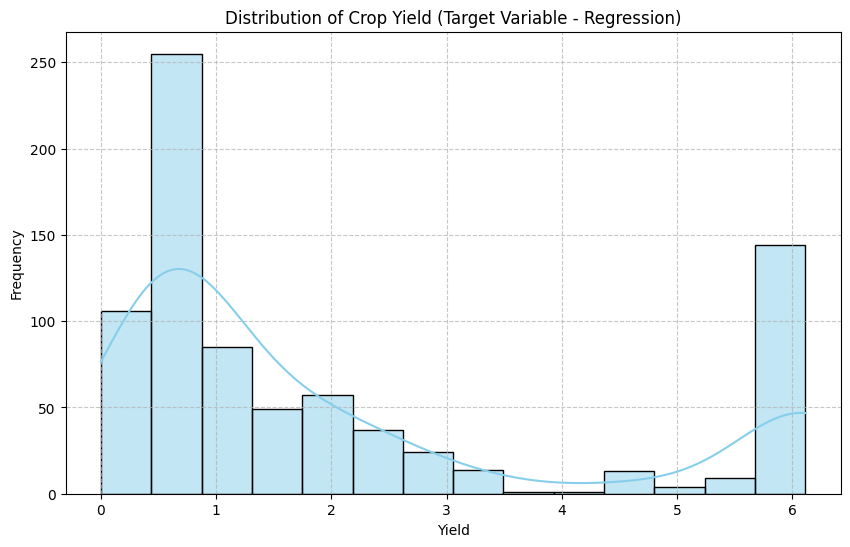

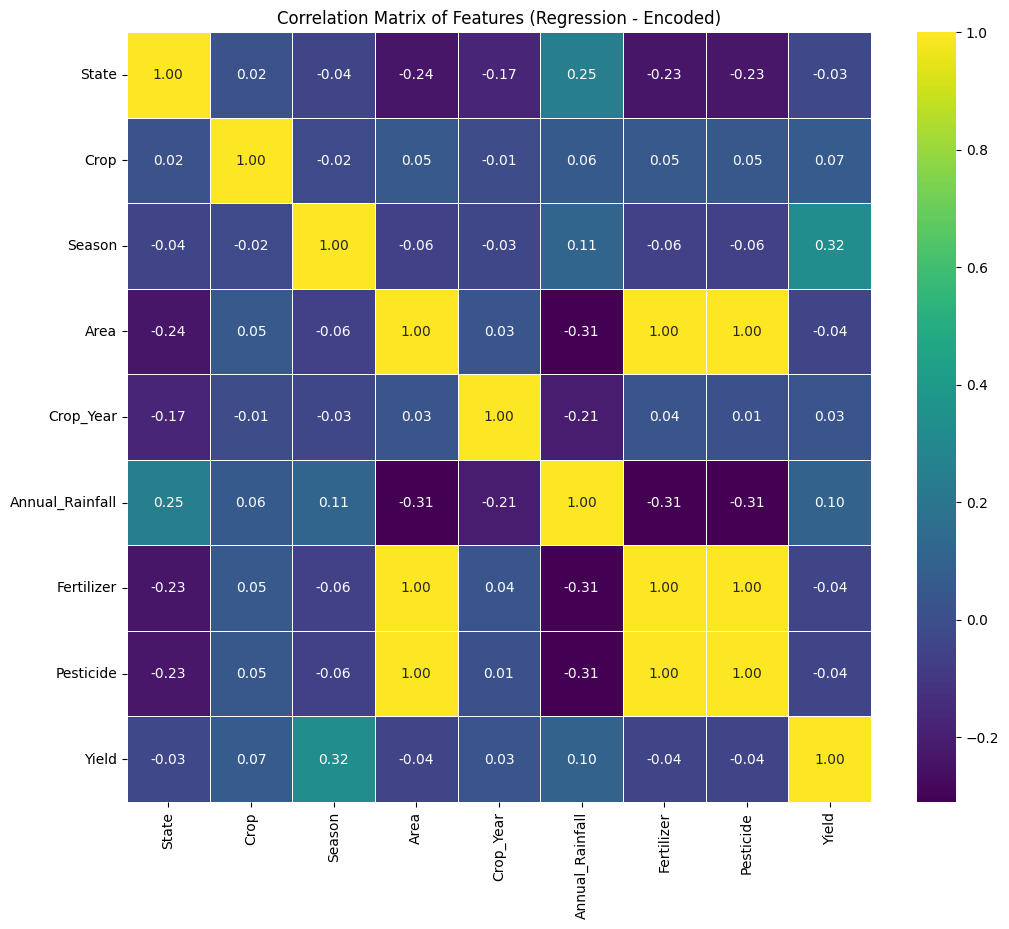

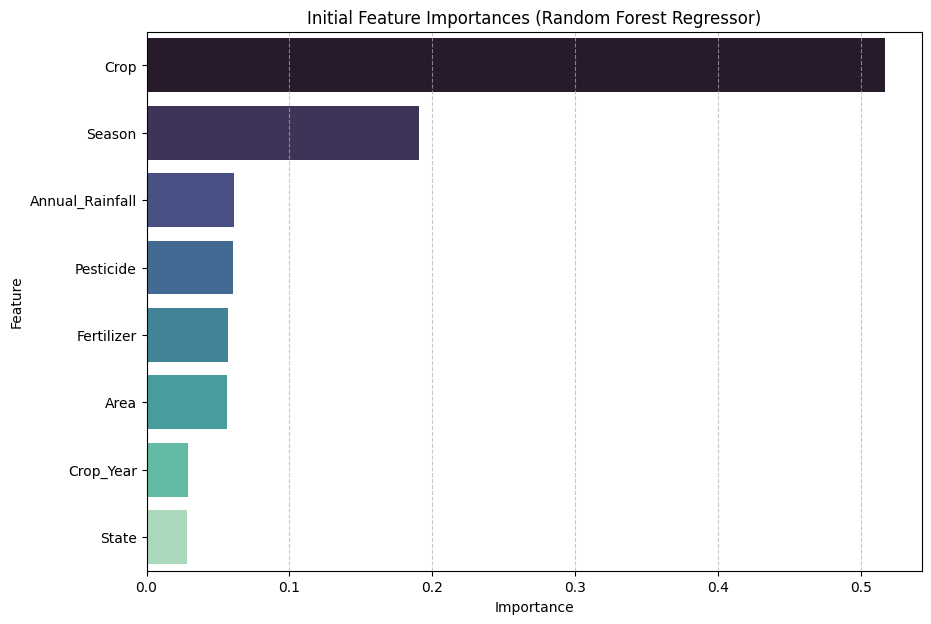


Generating pairplots (this might take a moment)...


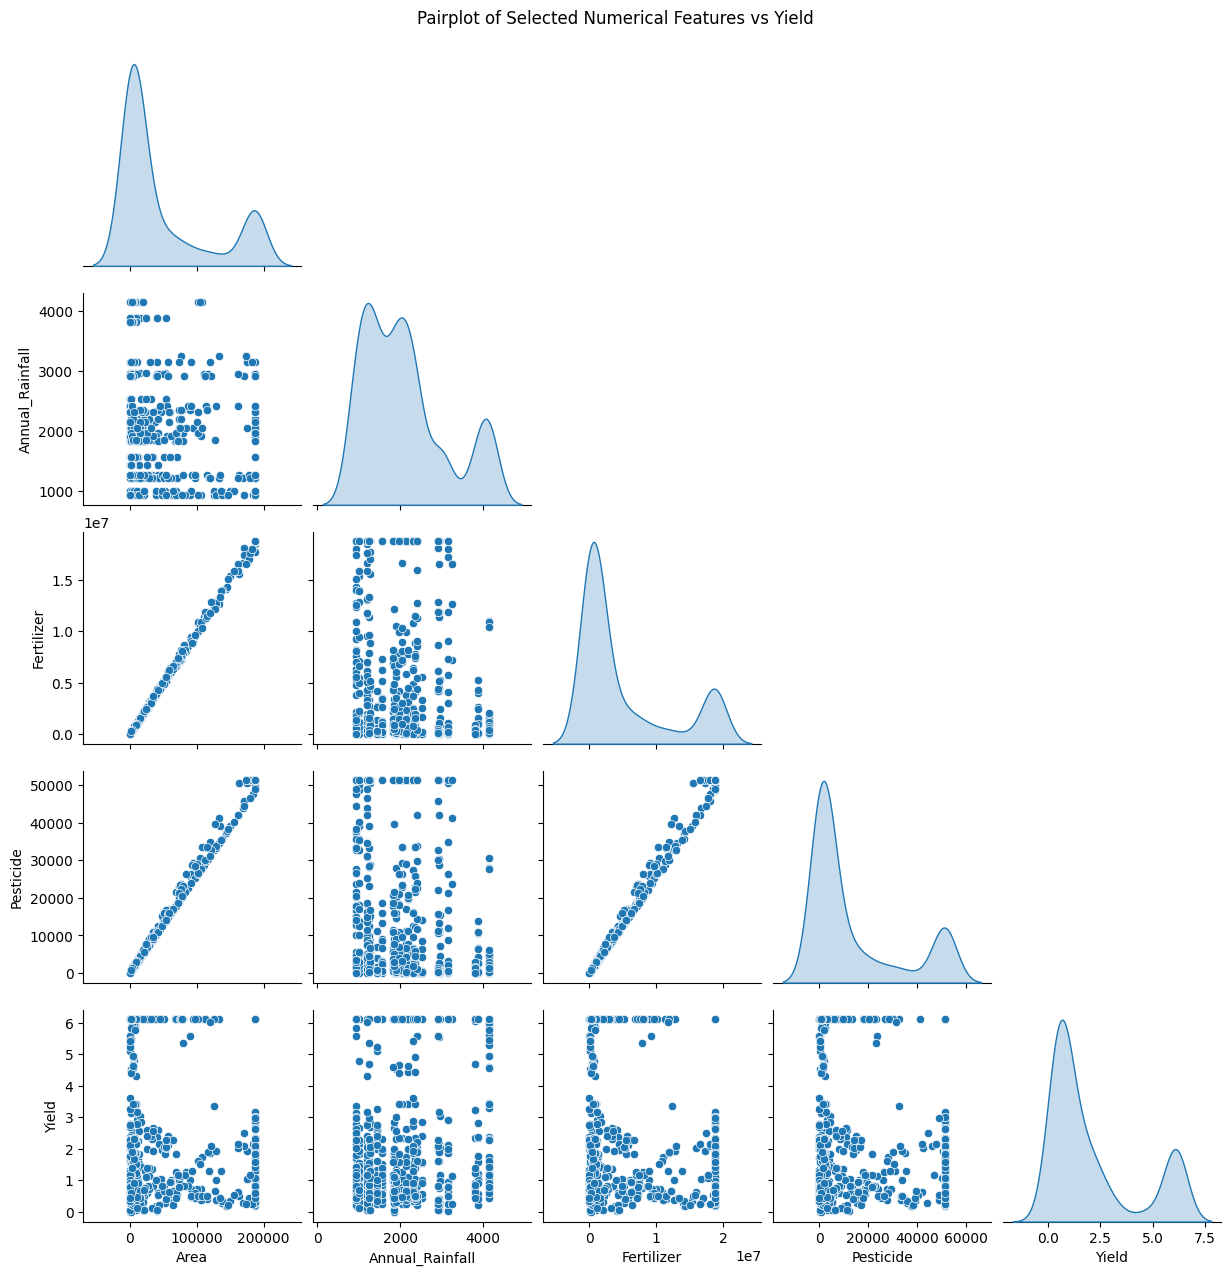

In [9]:
# Distribution of Yield (Target Variable)
plt.figure(figsize=(10, 6))
sns.histplot(y_train_reg, kde=True, color='skyblue')
plt.title('Distribution of Crop Yield (Target Variable - Regression)')
plt.xlabel('Yield')
plt.ylabel('Frequency')
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

# Correlation Matrix (Encoded Features)
plt.figure(figsize=(12, 10))
correlation_matrix_reg = pd.concat([X_train_reg, y_train_reg], axis=1).corr()
sns.heatmap(correlation_matrix_reg, annot=True, cmap='viridis', fmt=".2f", linewidths=.5)
plt.title('Correlation Matrix of Features (Regression - Encoded)')
plt.show()

# Feature Importances from a baseline RandomForestRegressor (before extensive tuning)
temp_rf = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
temp_rf.fit(X_train_reg_scaled, y_train_reg)
importances = pd.Series(temp_rf.feature_importances_, index=X_reg.columns).sort_values(ascending=False)

plt.figure(figsize=(10, 7))
sns.barplot(x=importances, y=importances.index, palette='mako')
plt.title('Initial Feature Importances (Random Forest Regressor)')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.grid(True, linestyle='--', alpha=0.7, axis='x')
plt.show()

# Pairplots for a subset of numerical features against Yield (can be slow for many features)
# Using original unscaled training data (X_train_reg, y_train_reg) for interpretability
print("\nGenerating pairplots (this might take a moment)...")
pairplot_df = X_train_reg.copy()
pairplot_df['Yield'] = y_train_reg
numerical_subset_for_pairplot = ['Area', 'Annual_Rainfall', 'Fertilizer', 'Pesticide', 'Yield']
sns.pairplot(pairplot_df[numerical_subset_for_pairplot], diag_kind='kde', corner=True)
plt.suptitle('Pairplot of Selected Numerical Features vs Yield', y=1.02)
plt.show()

In [10]:
print("\n--- Training XGBoost Regressor ---")
xgb_model = xgb.XGBRegressor(objective='reg:squarederror', random_state=42, n_jobs=-1)

# Hyperparameter Tuning for XGBoost
param_grid_xgb = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7, 9],
    'learning_rate': [0.01, 0.05, 0.1],
    'subsample': [0.7, 0.8, 0.9],
    'colsample_bytree': [0.7, 0.8, 0.9]
}
# For faster tuning during development, reduce cv or parameter space
# grid_search_xgb = GridSearchCV(estimator=xgb_model, param_grid=param_grid_xgb,
#                                cv=3, n_jobs=-1, verbose=2, scoring='r2')
# Using fewer options for faster demo:
grid_search_xgb = GridSearchCV(estimator=xgb_model,
                               param_grid={'n_estimators': [100, 200], 'max_depth': [5, 7], 'learning_rate': [0.05, 0.1]},
                               cv=2, n_jobs=-1, verbose=1, scoring='r2')

grid_search_xgb.fit(X_train_reg_scaled, y_train_reg)
best_xgb_model = grid_search_xgb.best_estimator_
print(f"\nBest XGBoost Params: {grid_search_xgb.best_params_}")
print(f"Best XGBoost R2 score on CV: {grid_search_xgb.best_score_:.4f}")

y_pred_xgb_reg = best_xgb_model.predict(X_test_reg_scaled)
xgb_rmse = np.sqrt(mean_squared_error(y_test_reg, y_pred_xgb_reg))
xgb_r2 = r2_score(y_test_reg, y_pred_xgb_reg)
xgb_mae = mean_absolute_error(y_test_reg, y_pred_xgb_reg)

print("\nXGBoost Regressor Metrics on Test Set:")
print(f"RMSE: {xgb_rmse:.4f}")
print(f"R2 Score: {xgb_r2:.4f}")
print(f"MAE: {xgb_mae:.4f}")

# Cross-validation score on the full dataset (for a more robust estimate if not done in GridSearchCV extensively)
# scores = cross_val_score(best_xgb_model, X_reg_scaled_df, y_reg, cv=5, scoring='r2', n_jobs=-1) # X_reg_scaled_df does not exist, should be on combined scaled data
# print(f"\nCross-validated R2 scores: {scores}")
# print(f"Average R2 score: {np.mean(scores):.4f} (+/- {np.std(scores):.4f})")


--- Training XGBoost Regressor ---
Fitting 2 folds for each of 8 candidates, totalling 16 fits

Best XGBoost Params: {'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 200}
Best XGBoost R2 score on CV: 0.7145

XGBoost Regressor Metrics on Test Set:
RMSE: 0.7068
R2 Score: 0.8860
MAE: 0.3777


In [11]:
print("\n--- Training LightGBM for Quantile Regression ---")
# Lower bound (e.g., 5th percentile - for 90% CI)
lgb_lower = lgb.LGBMRegressor(objective='quantile', alpha=0.05, metric='quantile', random_state=42, verbosity=-1)
lgb_lower.fit(X_train_reg_scaled, y_train_reg)
y_pred_lower_reg = lgb_lower.predict(X_test_reg_scaled)

# Upper bound (e.g., 95th percentile - for 90% CI)
lgb_upper = lgb.LGBMRegressor(objective='quantile', alpha=0.95, metric='quantile', random_state=42, verbosity=-1)
lgb_upper.fit(X_train_reg_scaled, y_train_reg)
y_pred_upper_reg = lgb_upper.predict(X_test_reg_scaled)

# Evaluate quantile coverage
coverage = np.mean((y_test_reg >= y_pred_lower_reg) & (y_test_reg <= y_pred_upper_reg))
interval_width = np.mean(y_pred_upper_reg - y_pred_lower_reg)
print(f"\nQuantile Coverage (5th-95th percentile) on Test Set: {coverage*100:.2f}%")
print(f"Average Interval Width on Test Set: {interval_width:.4f}")


--- Training LightGBM for Quantile Regression ---

Quantile Coverage (5th-95th percentile) on Test Set: 89.00%
Average Interval Width on Test Set: 5.3827



--- Generating SHAP Explanations for Regression Model ---
Displaying SHAP summary plots...


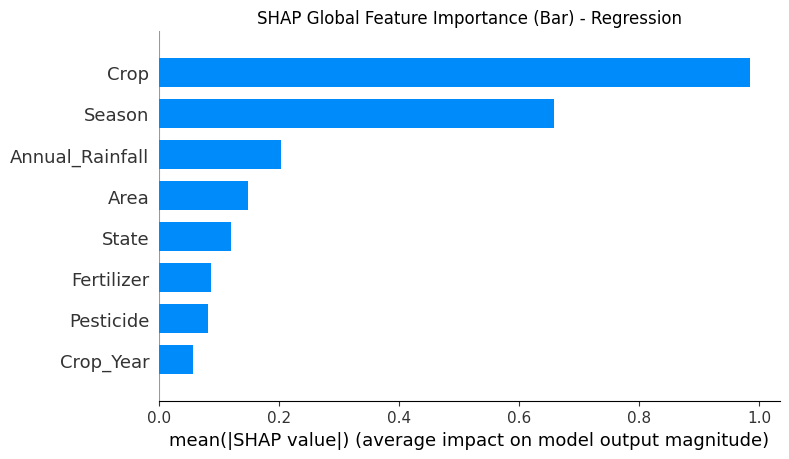

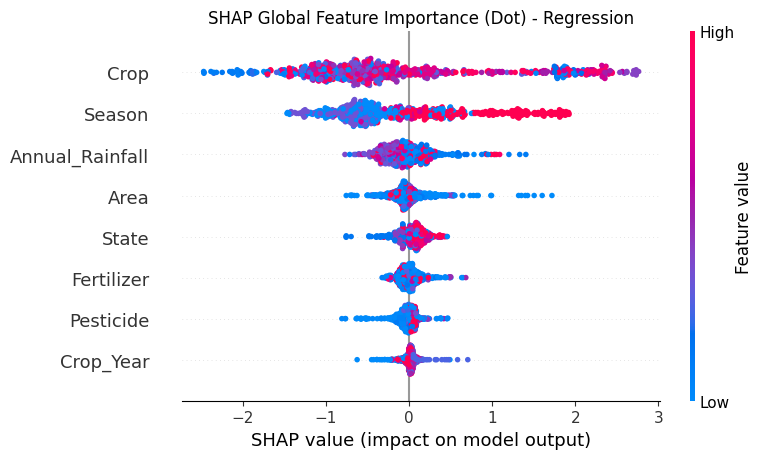

Displaying SHAP waterfall plot for a single instance...


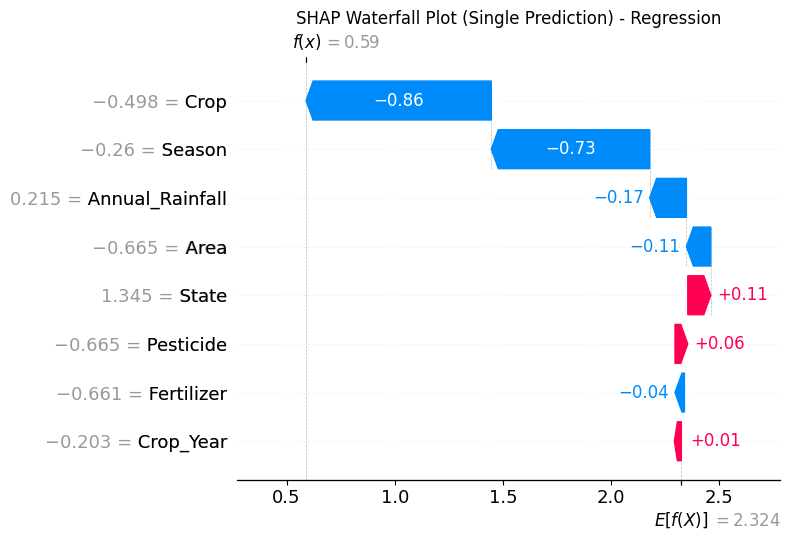

In [12]:
print("\n--- Generating SHAP Explanations for Regression Model ---")
# Ensure background data for TreeExplainer is a DataFrame if possible, or a sample
# Using X_train_reg_scaled_df which is already a DataFrame
explainer_reg = shap.TreeExplainer(best_xgb_model, X_train_reg_scaled_df)
shap_values_train_reg = explainer_reg.shap_values(X_train_reg_scaled_df)

# Summary Plot (Global Feature Importance)
print("Displaying SHAP summary plots...")
plt.figure()
shap.summary_plot(shap_values_train_reg, X_train_reg_scaled_df, plot_type="bar", show=False)
plt.title("SHAP Global Feature Importance (Bar) - Regression")
plt.tight_layout()
plt.show()

plt.figure()
shap.summary_plot(shap_values_train_reg, X_train_reg_scaled_df, show=False)
plt.title("SHAP Global Feature Importance (Dot) - Regression")
plt.tight_layout()
plt.show()

# Example of a single prediction explanation (Waterfall plot for the first test instance)
if len(X_test_reg_scaled_df) > 0:
    print("Displaying SHAP waterfall plot for a single instance...")
    expected_value_reg = explainer_reg.expected_value
    if isinstance(expected_value_reg, np.ndarray):
        expected_value_reg = expected_value_reg[0]

    shap_values_single_instance_reg = explainer_reg.shap_values(X_test_reg_scaled_df.iloc[0])
    
    plt.figure()
    shap.waterfall_plot(shap.Explanation(values=shap_values_single_instance_reg,
                                         base_values=expected_value_reg,
                                         data=X_test_reg_scaled_df.iloc[0].values,
                                         feature_names=X_test_reg_scaled_df.columns.tolist()),
                        show=False)
    plt.title("SHAP Waterfall Plot (Single Prediction) - Regression")
    plt.tight_layout() # Adjust layout to prevent labels from overlapping
    plt.show()
else:
    print("Test set for regression is empty, cannot generate waterfall plot.")

In [13]:
model_data = {
    'model': best_xgb_model,
    'model_lower': lgb_lower,
    'model_upper': lgb_upper,
    'label_encoders': label_encoders_reg, # Use encoders specific to regression
    'scaler': scaler_reg,                 # Use scaler specific to regression
    'feature_names': feature_names_ordered, # Original feature names in order used for df creation
    'categorical_mappings': categorical_mappings, # For dropdowns
    'explainer': explainer_reg,             # SHAP explainer for regression
    'model_name': 'XGBoost Regressor with Quantiles & SHAP'
}

with open('model.pkl', 'wb') as file:
    pickle.dump(model_data, file)

print("\nRegression model and associated components saved to model.pkl")


Regression model and associated components saved to model.pkl



--- Starting Classification Task: Predicting Yield Trend ---
Shape before dropping NaNs from shifts (Classification): (999, 18)
Shape after dropping NaNs from shifts (Classification): (771, 18)

Class distribution for Yield Trend:
0    0.505837
1    0.494163
Name: proportion, dtype: float64

Shape after SMOTE (Classification): (584, 12) (584,)
Class distribution after SMOTE (Classification): 0    0.5
1    0.5
Name: proportion, dtype: float64

--- Decision Tree Classifier ---
Classification Report (Decision Tree):
              precision    recall  f1-score   support

           0       0.54      0.55      0.55        98
           1       0.53      0.52      0.52        95

    accuracy                           0.53       193
   macro avg       0.53      0.53      0.53       193
weighted avg       0.53      0.53      0.53       193


--- Random Forest Classifier ---
Classification Report (Random Forest):
              precision    recall  f1-score   support

           0       0.53  

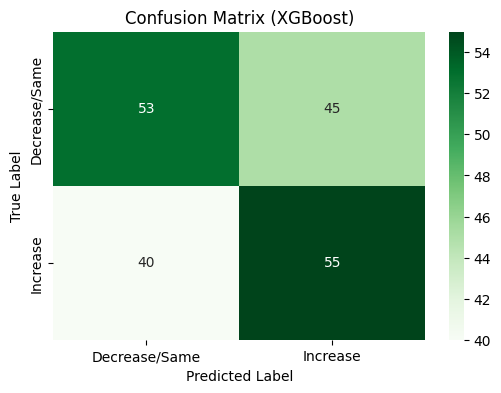

In [14]:
print("\n--- Starting Classification Task: Predicting Yield Trend ---")

df_class = df_class_orig.copy() # Use original data for classification
if 'Production' in df_class.columns:
    df_class = df_class.drop(columns=['Production'])

# Trim whitespace from object columns
for col in df_class.select_dtypes(include='object').columns:
    df_class[col] = df_class[col].str.strip()

# Impute missing values (as done for regression)
for col in df_class.select_dtypes(include=np.number).columns:
    if df_class[col].isnull().any():
        df_class[col] = df_class[col].fillna(df_class[col].median())
for col in df_class.select_dtypes(include='object').columns:
    if df_class[col].isnull().any():
        df_class[col] = df_class[col].fillna(df_class[col].mode()[0])

# Sort by State, Crop, and then Crop_Year for correct previous yield calculation
df_class = df_class.sort_values(by=['State', 'Crop', 'Crop_Year'])

# Feature Engineering: Differences (Example) & Previous Yield
feature_eng_cols = ['Annual_Rainfall', 'Fertilizer', 'Pesticide', 'Area']
for col_fe in feature_eng_cols:
    df_class[f'Prev_{col_fe}'] = df_class.groupby(['State', 'Crop'])[col_fe].shift(1)
    df_class[f'Diff_{col_fe}'] = df_class[col_fe] - df_class[f'Prev_{col_fe}']
df_class["Previous_Yield_Value"] = df_class.groupby(['State', 'Crop'])["Yield"].shift(1) # Renamed to avoid confusion

print(f"Shape before dropping NaNs from shifts (Classification): {df_class.shape}")
df_class_cleaned = df_class.dropna()
print(f"Shape after dropping NaNs from shifts (Classification): {df_class_cleaned.shape}")

if not df_class_cleaned.empty and df_class_cleaned.shape[0] > 50: # Min data threshold
    y_classification_target = (df_class_cleaned["Yield"] > df_class_cleaned["Previous_Yield_Value"]).astype(int)
    
    print("\nClass distribution for Yield Trend:")
    print(y_classification_target.value_counts(normalize=True))

    features_to_drop_class = ['Yield', 'Previous_Yield_Value'] + [f'Prev_{col_fe}' for col_fe in feature_eng_cols]
    X_class_df = df_class_cleaned.drop(columns=features_to_drop_class)
    
    # Ensure correct feature order for classification X
    # Using feature_names_ordered which includes original State, Crop, Season + numerical + new Diff_ features
    current_class_features = feature_names_ordered + [f'Diff_{col_fe}' for col_fe in feature_eng_cols]
    X_class_df = X_class_df[[col for col in current_class_features if col in X_class_df.columns]] # Keep only existing columns in order

    label_encoders_class = {}
    for col in ['State', 'Crop', 'Season']: # Assuming these are still the categorical ones needed
        if col in X_class_df.columns:
            X_class_df[col] = X_class_df[col].astype(str) # Ensure string type
            le_class = LabelEncoder()
            X_class_df[col] = le_class.fit_transform(X_class_df[col])
            label_encoders_class[col] = le_class # Not saving these in model.pkl for now
            
    X_train_class, X_test_class, y_train_class, y_test_class = train_test_split(
        X_class_df, y_classification_target, test_size=0.25, random_state=42, # Using 25% test for classification
        stratify=y_classification_target if y_classification_target.nunique() > 1 else None
    )
    
    numerical_cols_class = X_class_df.select_dtypes(include=np.number).columns
    scaler_class = StandardScaler()
    
    X_train_class_scaled = X_train_class.copy()
    X_test_class_scaled = X_test_class.copy()
    X_train_class_scaled[numerical_cols_class] = scaler_class.fit_transform(X_train_class[numerical_cols_class])
    X_test_class_scaled[numerical_cols_class] = scaler_class.transform(X_test_class[numerical_cols_class])

    smote = SMOTE(random_state=42)
    X_train_resampled, y_train_resampled = X_train_class_scaled, y_train_class # Default to no resampling
    if X_train_class_scaled.shape[0] > 0 and y_train_class.nunique() > 1:
        minority_class_count = y_train_class.value_counts().min()
        smote_k_neighbors = min(5, minority_class_count - 1) if minority_class_count > 1 else 1
        if smote_k_neighbors > 0:
            smote = SMOTE(random_state=42, k_neighbors=smote_k_neighbors)
            X_train_resampled, y_train_resampled = smote.fit_resample(X_train_class_scaled, y_train_class)
            print("\nShape after SMOTE (Classification):", X_train_resampled.shape, y_train_resampled.shape)
            print("Class distribution after SMOTE (Classification):", pd.Series(y_train_resampled).value_counts(normalize=True)) # pd.Series for value_counts
        else:
            print("\nNot enough samples in minority class for SMOTE. Using original training data for classification.")
    else:
        print("\nTraining data for classification is empty or has only one class. Skipping SMOTE.")

    models_to_test_class = {
        "Decision Tree": DecisionTreeClassifier(random_state=42, class_weight='balanced'),
        "Random Forest": RandomForestClassifier(random_state=42, class_weight='balanced', n_estimators=150, max_depth=10, min_samples_split=5),
    }
    
    # Calculate scale_pos_weight for XGBoost if applicable
    counts_resampled = pd.Series(y_train_resampled).value_counts()
    scale_pos_weight_xgb = 1.0
    if len(counts_resampled) > 1 and counts_resampled.get(0, 0) > 0 and counts_resampled.get(1, 0) > 0:
        scale_pos_weight_xgb = counts_resampled[0] / counts_resampled[1]
    
    models_to_test_class["XGBoost"] = xgb.XGBClassifier(random_state=42, scale_pos_weight=scale_pos_weight_xgb, 
                                                        eval_metric='logloss', n_estimators=150, learning_rate=0.05, max_depth=5)

    best_classifier_name = None
    best_f1_score = -1

    for name, classifier_model in models_to_test_class.items():
        print(f"\n--- {name} Classifier ---")
        classifier_model.fit(X_train_resampled, y_train_resampled)
        y_pred_clf = classifier_model.predict(X_test_class_scaled)
        
        print(f"Classification Report ({name}):")
        report = classification_report(y_test_class, y_pred_clf, zero_division=0, output_dict=True)
        print(classification_report(y_test_class, y_pred_clf, zero_division=0))
        
        current_f1 = report['weighted avg']['f1-score']
        if current_f1 > best_f1_score:
            best_f1_score = current_f1
            best_classifier_name = name
            best_classifier_predictions = y_pred_clf

    if best_classifier_name:
        print(f"\n--- Best Classifier: {best_classifier_name} (based on weighted F1-score) ---")
        cm_best = confusion_matrix(y_test_class, best_classifier_predictions)
        plt.figure(figsize=(6,4))
        sns.heatmap(cm_best, annot=True, fmt='d', cmap='Greens', 
                    xticklabels=['Decrease/Same', 'Increase'], yticklabels=['Decrease/Same', 'Increase'])
        plt.title(f'Confusion Matrix ({best_classifier_name})')
        plt.xlabel('Predicted Label')
        plt.ylabel('True Label')
        plt.show()
else:
    print("\nDataFrame for classification is too small after processing NaNs. Classification task skipped.")